# 2019 Canadian Election tweets
# OSEMN Step 2: Scrub
# Cleanup of Sentiment 140 dataset
# Removal of duplicates

This notebook describes part of Step 2: Scrub of OSEMN methodology. It covers cleanup of Sentiment 140.

Cleanup plan:

1. Duplicate checks
2. Remove duplicated mislabelled tweets
3. Remove users with high count of tweets (tweeter bots, duplicated posts)

## Import dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from time import time

sns.set()

In [2]:
sys.path.append('../../src')
from proc_utils import duplicate_check

In [3]:
data_dir = '../../data/sentiment140/'
os.listdir(data_dir)

['testdata.manual.2009.06.14.csv',
 'training.1600000.processed.noemoticon.csv',
 'sentiment140_train_nodup.csv',
 'sentiment140_train_cleaned.csv']

## Load Sentiment 140 dataset

In [4]:
t = time()
df = pd.read_csv(data_dir + 'sentiment140_train_cleaned.csv')
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) +
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) +
      "\n-- Column names:\n", df.columns)


----- DataFrame loaded
in 5.56 seconds
with 1,599,306 rows
and 8 columns
-- Column names:
 Index(['sentiment', 'ids', 'date', 'query', 'user', 'text', 'hashtags',
       'handles'],
      dtype='object')


## Duplicate check

### Duplicate check criteria

Duplicate checks have been performed with the following criteria used for detection:

* all columns (entries must match on all columns to be considered duplicated)

* each column excluded one by one from the list, check performed with the rest

* date+user+text (same date, same user, same text)

* user+text (same user, same text)

* id+text (same tweet id, same text)

### Duplicate check results

* there are some misclassified records -- they match in everything, but have different `'class'`

* there are some users with a much higher number of posts than the mean

* there are some twitter bots present in the dataset

* users can post duplicated tweets

Subset 'all_columns': 0 (0.00% of total 1,599,306) records are detected as duplicated.
Subset 'date+user+text': 1,880 (0.12% of total 1,599,306) records are detected as duplicated.
Subset 'user+text': 6,727 (0.42% of total 1,599,306) records are detected as duplicated.
Subset 'id+text': 1,684 (0.11% of total 1,599,306) records are detected as duplicated.


,all_columns,date+user+text,user+text,id+text
num_duplicates,0.0,1.880000e+03,6.727000e+03,1.684000e+03
num_total,1599306.0,1.599306e+06,1.599306e+06,1.599306e+06
percentage,0.0,1.175510e-01,4.206199e-01,1.052957e-01


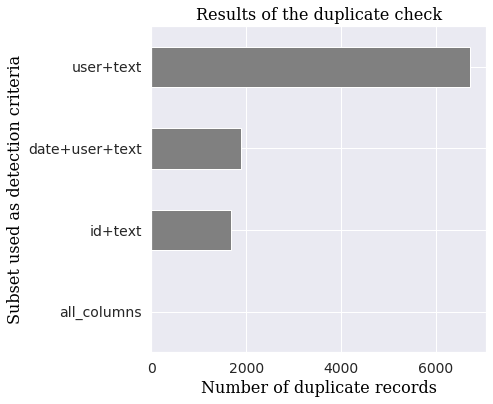

In [5]:
subsets_to_check = {
    'date+user+text': ['date', 'user', 'text'],
    'user+text': ['user', 'text'],
    'id+text': ['ids', 'text']
}

# added columns 'hashtags' and 'handles' are excluded from the check
duplicate_check(df.drop(['hashtags', 'handles'], axis=1), 
                subsets_to_check=subsets_to_check)

## Remove duplicated mislabelled tweets

In [6]:
df.drop('sentiment', axis=1).duplicated().sum()

1684

Duplicate check using all columns (with `'sentiment'` excluded) detects 1684 duplicates -- these pairs of records are identical in everything, but one is classified as "positive", and another one as "negative".

In [7]:
# get the list of 'id's of all rows that have 2 records under the same 'id' 
ids = df['ids'].value_counts()[df['ids'].value_counts() == 2].index
mask = df['ids'].isin(ids)
df[mask].sort_values('user').head(10)

,sentiment,ids,date,query,user,text,hashtags,handles
135660,0,1879941003,2009-05-21 23:36:00,NO_QUERY,007peter,naniwaialeale no not keith olbermann he annoy ...,NaN,@NaniWaialeale
999760,4,1879941003,2009-05-21 23:36:00,NO_QUERY,007peter,naniwaialeale no not keith olbermann he annoy ...,NaN,@NaniWaialeale
1193803,4,1984377787,2009-05-31 14:59:31,NO_QUERY,15AMR,i m broke cuz she got all she wanted going hoe...,NaN,NaN
254966,0,1984377787,2009-05-31 14:59:31,NO_QUERY,15AMR,i m broke cuz she got all she wanted going hoe...,NaN,NaN
258264,0,1985150195,2009-05-31 16:32:00,NO_QUERY,19fischi75,impala_guy yeah this is really annoying will s...,NaN,@Impala_Guy
469334,0,2176210509,2009-06-15 03:14:01,NO_QUERY,19fischi75,impala_guy sorry missed again the boss was her...,NaN,@Impala_Guy
1519893,4,2176210509,2009-06-15 03:14:01,NO_QUERY,19fischi75,impala_guy sorry missed again the boss was her...,NaN,@Impala_Guy
1198259,4,1985150195,2009-05-31 16:32:00,NO_QUERY,19fischi75,impala_guy yeah this is really annoying will s...,NaN,@Impala_Guy
71982,0,1694107135,2009-05-04 01:06:58,NO_QUERY,26Neil,i love camp fires i just wish the kids would t...,NaN,NaN
900538,4,1694107135,2009-05-04 01:06:58,NO_QUERY,26Neil,i love camp fires i just wish the kids would t...,NaN,NaN


In [8]:
mask1 = df.drop('sentiment', axis=1).duplicated()
df = df[~mask1]
print("{0:,} records remaining in the DataFrame.".format(len(df)))


1,597,622 records remaining in the DataFrame.


## Users with a high frequency of tweets

In [9]:
df['user'].value_counts()

lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
                  ... 
Emma_Dowie           1
niteshbhatia         1
hellodomii           1
nikki71              1
alarizzy             1
Name: user, Length: 659459, dtype: int64

In [10]:
df['user'].value_counts().describe()

count    659459.000000
mean          2.422625
std           4.703843
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         549.000000
Name: user, dtype: float64

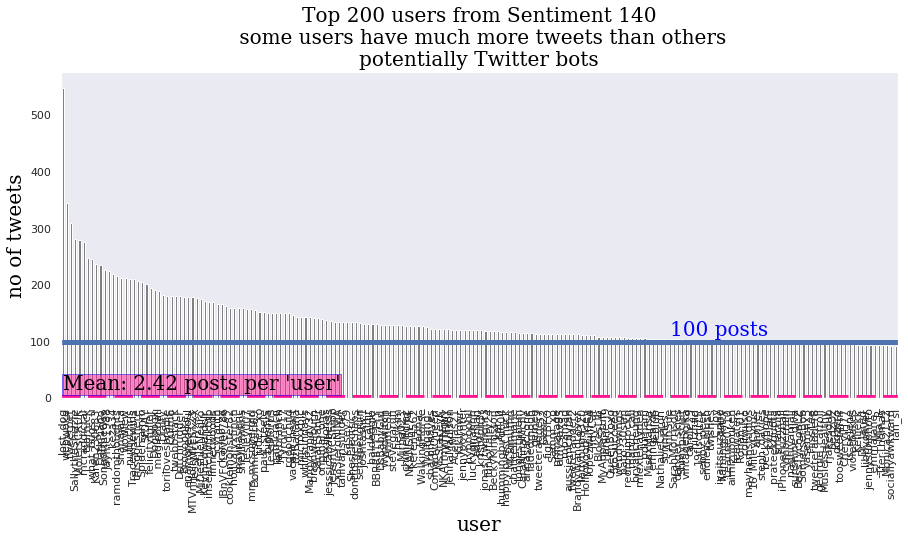

In [11]:
# create figure and axis
f, ax = plt.subplots(1, figsize=(15, 6))
font_mean = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 20,
            }

font_labels = {'family': 'serif',
               'color':  'black',
               'weight': 'normal',
               'size': 20,
               }

# plot value counts for top 30 users by # of records
df['user'].value_counts().head(200).plot(kind='bar', color='gray', ax=ax)

# plot the mean
mean = df['user'].value_counts().mean()
ax.axhline(mean, color='deeppink', linestyle='--', linewidth=5)
ax.text(0, 
        mean * 6, 
        "Mean: {0:.2f} posts per 'user'".format(mean), 
        fontdict=font_mean,
        bbox=dict(facecolor='deeppink', edgecolor='blue', pad=1.0, alpha=0.5))
ax.set_xlabel("user", fontdict=font_labels)
ax.set_ylabel("no of tweets", fontdict=font_labels)
ax.set_title("Top 200 users from Sentiment 140\n \
some users have much more tweets than others\npotentially Twitter bots", fontdict=font_labels)
ax.axhline(100, linewidth=5)
ax.text(145, 110, "100 posts", fontdict={'family': 'serif', 'color': 'blue', 'size':'20'})
plt.grid(False)
f.savefig('results/tweets_per_user.png', bbox_inches='tight')

## Twitter bots
Some of the users with a large number of tweets correspond to tweeter bots.

In [12]:
mask1 = df['user'] == 'tweetpet'
df.loc[mask1, ['date', 'user', 'text']]


,date,user,text
9560,2009-04-17 22:00:01,tweetpet,tweetchild clean me
9561,2009-04-17 22:00:01,tweetpet,tweetchild clean me
9562,2009-04-17 22:00:02,tweetpet,chromachris clean me
9564,2009-04-17 22:00:03,tweetpet,reatlas clean me
9565,2009-04-17 22:00:03,tweetpet,chromachris clean me
...,...,...,...
49679,2009-05-02 06:00:37,tweetpet,amateurdelta54 clean me
49680,2009-05-02 06:00:38,tweetpet,littleblue62 clean me
49681,2009-05-02 06:00:39,tweetpet,shawn1976 clean me
49694,2009-05-02 06:01:02,tweetpet,tkgfmb hungry type feed to feed me


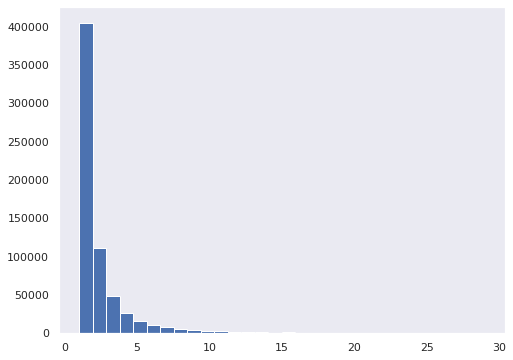

In [13]:
max_tweets = 30
mask1 = df['user'].value_counts() < max_tweets
df['user'].value_counts()[mask1].hist(bins=max_tweets, figsize=(8, 6))
plt.grid(False)

## Remove users with a high frequency of tweets

In [14]:
max_tweets = 15
mask1 = df['user'].value_counts() > max_tweets
num_unique_users = df['user'].nunique()
num_hf_users = mask1.sum()
print("DataFrame contains {0:,} unique users, out of them {1:,} ({2:.2f}%) have more than {3} tweets".
      format(num_unique_users, num_hf_users, num_hf_users / num_unique_users, max_tweets))

DataFrame contains 659,459 unique users, out of them 9,555 (0.01%) have more than 15 tweets


In [15]:
max_tweets = 15
mask1 = df['user'].value_counts() > max_tweets
drop_ids = mask1[mask1 == True].index
drop_mask = df['user'].isin(drop_ids)
df = df[~drop_mask]
print("{0:,} records remaining in the DataFrame.".format(len(df)))

1,314,520 records remaining in the DataFrame.


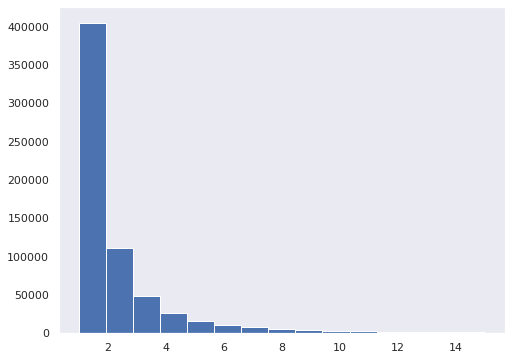

In [16]:
df['user'].value_counts().hist(bins=15, figsize=(8, 6))
plt.grid(False)

## Some users post duplicated posts (maybe more bots)

Subset 'all_columns': 0 (0.00% of total 1,314,520) records are detected as duplicated.
Subset 'date+user+text': 154 (0.01% of total 1,314,520) records are detected as duplicated.
Subset 'user+text': 2,799 (0.21% of total 1,314,520) records are detected as duplicated.
Subset 'id+text': 0 (0.00% of total 1,314,520) records are detected as duplicated.


,all_columns,date+user+text,user+text,id+text
num_duplicates,0.0,1.540000e+02,2.799000e+03,0.0
num_total,1314520.0,1.314520e+06,1.314520e+06,1314520.0
percentage,0.0,1.171530e-02,2.129294e-01,0.0


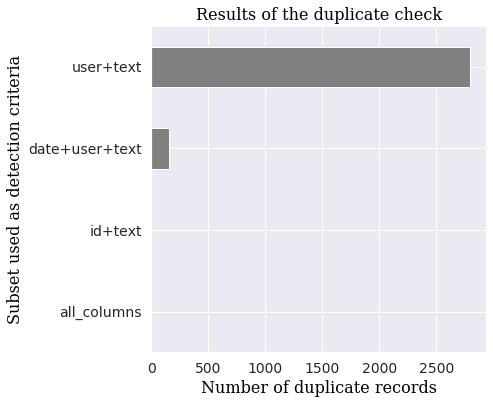

In [17]:
subsets_to_check = {
    'date+user+text': ['date', 'user', 'text'],
    'user+text': ['user', 'text'],
    'id+text': ['ids', 'text']
}

# added columns 'hashtags' and 'handles' are excluded from the check
duplicate_check(df.drop(['hashtags', 'handles'], axis=1), 
                subsets_to_check=subsets_to_check)

In [18]:
mask1 = df.duplicated(subset=['user', 'text'], keep=False)
df.loc[mask1, ['date', 'user', 'text']].sort_values('user').tail(10)

,date,user,text
161059,2009-05-28 23:49:17,ziggywas,summer glau to appear in dollhouse next year i...
154775,2009-05-27 07:18:32,zio5t4n,all_lies_about
703334,2009-06-20 11:41:45,zio5t4n,all_lies_about
1385191,2009-06-06 01:57:28,zoliky,how to run mac os x on pc 100 compatibility we...
1385143,2009-06-06 01:56:09,zoliky,how to run mac os x on pc 100 compatibility we...
800632,2009-04-06 23:03:31,zottarella,lets drop ich hatte gerade k se auf toast germ...
810404,2009-04-07 07:30:20,zottarella,lets drop ich hatte gerade k se auf toast germ...
801783,2009-04-07 00:03:33,zottarella,lets drop ich hatte gerade k se auf toast germ...
871025,2009-05-02 07:12:54,zyozyfounder,gabrielrossi this is so brilliant i m going re...
871024,2009-05-02 07:12:54,zyozyfounder,gabrielrossi this is so brilliant i m going re...


In [19]:
df = df[~mask1]
print("{0:,} records remaining in the DataFrame.".format(len(df)))

1,309,540 records remaining in the DataFrame.


## Confirmatory duplicate check

Subset 'all_columns': 0 (0.00% of total 1,309,540) records are detected as duplicated.
Subset 'date+user+text': 0 (0.00% of total 1,309,540) records are detected as duplicated.
Subset 'user+text': 0 (0.00% of total 1,309,540) records are detected as duplicated.
Subset 'id+text': 0 (0.00% of total 1,309,540) records are detected as duplicated.


,all_columns,date+user+text,user+text,id+text
num_duplicates,0.0,0.0,0.0,0.0
num_total,1309540.0,1309540.0,1309540.0,1309540.0
percentage,0.0,0.0,0.0,0.0


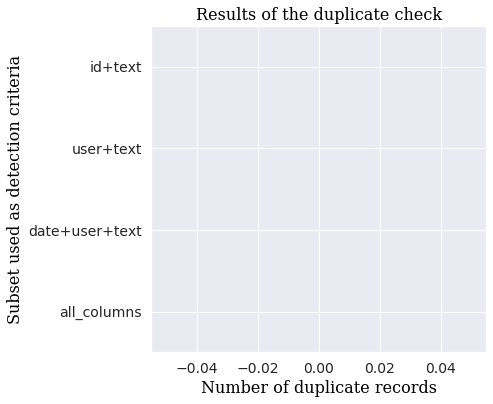

In [20]:
subsets_to_check = {
    'date+user+text': ['date', 'user', 'text'],
    'user+text': ['user', 'text'],
    'id+text': ['ids', 'text']
}

# added columns 'hashtags' and 'handles' are excluded from the check
duplicate_check(df.drop(['hashtags', 'handles'], axis=1), 
                subsets_to_check=subsets_to_check)

## Save results to a .csv file

In [21]:
save_path = data_dir + 'sentiment140_train_nodup.csv'
t = time()
df.to_csv(save_path, index=False)
elapsed = time() - t
print("DataFrame saved to file\n{0}\ntook {1:,.2f} seconds ({2:,.2f} minutes)"
      .format(save_path, elapsed, elapsed / 60))


DataFrame saved to file
../../data/sentiment140/sentiment140_train_nodup.csv
took 10.93 seconds (0.18 minutes)
